In [35]:
import numpy as np
import os
import matplotlib.pyplot as plt


import keras
from keras.models import Model
from keras.layers import Dense, Conv2D, Activation, BatchNormalization
from keras.layers import Input, Flatten, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10

In [4]:
(trainX, trainY), (testX, testY) = cifar10.load_data()

170500096/170498071 [==============================] - 16s 0us/step


In [5]:
trainX = trainX.astype('float32')/255
testX = testX.astype('float32')/255

In [6]:
trainX_mean = np.mean(trainX, axis=0)
trainX -= trainX_mean
testX -= trainX_mean

In [7]:
print("trainX shape: ", trainX.shape)
print("Number of training samples: ", trainX.shape[0])
print("Number of test samples: ", testX.shape[0])
print("trainY shape: ", trainY.shape)

trainX shape:  (50000, 32, 32, 3)
Number of training samples:  50000
Number of test samples:  10000
trainY shape:  (50000, 1)


In [8]:
num_classes = 10

In [9]:
trainY = keras.utils.to_categorical(trainY, num_classes)

In [10]:
testY = keras.utils.to_categorical(testY, num_classes)

In [1]:
def resnet_layer(inputs, filters=16, kernel_size=3, strides=1, activation='relu', batch_norm=True, conv=True):
    conv = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))

    if conv:
        inputs = conv(inputs)
        if batch_norm:
            inputs = BatchNormalization()(inputs)
        if activation is not None:
            inputs = Activation(activation)(inputs)
    else:
        if batch_norm:
            inputs = BatchNormalization()(inputs)
        if activation is not None:
            inputs = Activation(activation)(inputs)
        x = conv(x)
    return inputs

In [11]:
def resnet(input_shape, depth, num_classes=10):
    filters = 16
    res_blks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(res_blks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x, filters=filters, strides=strides)
            y = resnet_layer(inputs=y, filters=filters, activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x, filters=filters, kernel_size=1, strides=strides, activation=None, batch_norm=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [18]:
# Reference: https://keras.io/examples/cifar10_resnet/
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [16]:
model = resnet(input_shape=trainX.shape[1:], depth=20)

In [20]:
model_type = 'ResNet%dv%d' % (20, 1)

In [21]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=lr_schedule(0)), metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_norm_20 (BatchNo (None, 32, 32, 16)   64          conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 32, 32, 16)   0           batch_norm_20[0][0]     
________________________________________________________________________________________

In [22]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [23]:
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True)
scheduler = LearningRateScheduler(lr_schedule)
reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
callbacks = [checkpoint, reducer, scheduler]

In [26]:
model.fit(trainX, trainY, batch_size=32, epochs=10,validation_data=(testX, testY), shuffle=True,callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
Learning rate:  0.001
50000/50000 [==============================] - 75s 1ms/step - loss: 0.5443 - accuracy: 0.8840 - val_loss: 1.1631 - val_accuracy: 0.7207
Epoch 2/10
Learning rate:  0.001
50000/50000 [==============================] - 75s 1ms/step - loss: 0.5339 - accuracy: 0.8893 - val_loss: 1.1689 - val_accuracy: 0.7309
Epoch 3/10
Learning rate:  0.001
50000/50000 [==============================] - 75s 1ms/step - loss: 0.5133 - accuracy: 0.8976 - val_loss: 1.2161 - val_accuracy: 0.7475
Epoch 4/10
Learning rate:  0.001
50000/50000 [==============================] - 75s 1ms/step - loss: 0.5029 - accuracy: 0.9047 - val_loss: 1.0157 - val_accuracy: 0.7740
Epoch 5/10
Learning rate:  0.001
50000/50000 [==============================] - 75s 1ms/step - loss: 0.4916 - accuracy: 0.9110 - val_loss: 0.9206 - val_accuracy: 0.7827
Epoch 6/10
Learning rate:  0.001
50000/50000 [==============================] - 75s 1ms/step - loss: 0.48

In [28]:
scores = model.evaluate(testX, testY, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 3s 338us/step
Test loss: 1.2111467237472535
Test accuracy: 0.7694000005722046


In [32]:
model.predict(testX[0:1])

array([[4.9549192e-07, 1.5340975e-05, 2.2896305e-08, 9.9658847e-01,
        1.6211837e-08, 3.1539674e-03, 1.7006963e-04, 2.7656959e-08,
        5.2788288e-08, 7.1551782e-05]], dtype=float32)

In [36]:
def show_train_history(train_history, train, validation, title):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title(title)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc = 'upper left')
    plt.show()

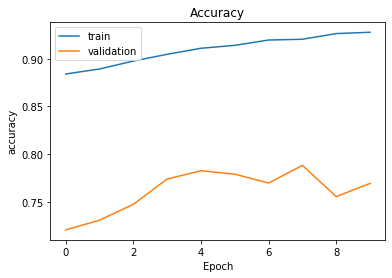

In [37]:
show_train_history(model.history, 'accuracy', 'val_accuracy', 'Accuracy')

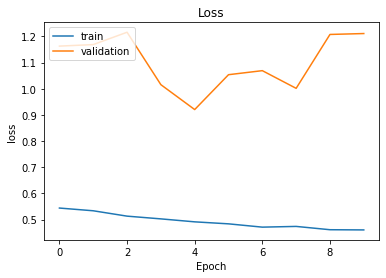

In [38]:
show_train_history(model.history, 'loss', 'val_loss', 'Loss')

# Reference
https://keras.io/examples/cifar10_resnet/